In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.neural_network import MLPRegressor
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
def LoadRawVariables():
    c2pt = []
    ts   = []
    taus = []
    xs   = []
    ys   = []
    zs   = []
    c3pt_S = []
    c3pt_V = []
    c3pt_A = []
    c2pt_OTHER = []
    
    
    for tau in range(0, 49, 8):
        for x in range(0, 25, 8):
            for y in range(0, 25, 8):
                for z in range(0, 25, 8):
                    for sample in range(748, 1421, 16):
                        fname = "../Data/T" + str(tau) + "/x" + str(x) + "y" + str(y) + "z" + str(z) + "/nuc3pt.dat." + str(sample)
                        if path.exists(fname):
                            with open(fname) as fp:
                                for i, line in enumerate(fp):
                                    if i >= 7 and i <= 70:           # The start of Gauss -> Point 2pt correlation functions
                                        c2pt_OTHER.append([float(x) for x in line.rstrip().split()[1:3]])
                                    if i >= 5182 and i <= 5245:      # The start of Gauss -> Gauss 2pt correlation functions
                                        c2pt.append([float(x) for x in line.rstrip().split()[1:3]])
                                        ts.append(i - 5182)
                                        taus.append(tau)
                                        xs.append(x)
                                        ys.append(y)
                                        zs.append(z)
                                    elif i >= 10154 and i <= 10217:
                                        c3pt_S.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i >= 10229 and i <= 10292:
                                        c3pt_V.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i >= 19979 and i <= 20042:
                                        c3pt_A.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i > 20042:
                                        break
    
    return ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER

ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER = LoadRawVariables()

c2pt_factor_raw = sum(np.array(c2pt)) / len(c2pt)
N_factor = np.sqrt(c2pt_factor_raw[0] ** 2 + c2pt_factor_raw[1] ** 2)

for i in range(len(c2pt)):
    for j in range(2):
        c2pt[i][j] /= N_factor
        c2pt_OTHER[i][j] /= N_factor
    for j in range(4):
        c3pt_S[i][j] /= N_factor
        c3pt_V[i][j] /= N_factor
        c3pt_A[i][j] /= N_factor

In [3]:
## Features is a 64 x <# Data> x <Size Data> 3D array for all 64 sets of lists of features
## Labels is a 64 x <# Data> 2D array for all 64 sets of lists of labels

features_unshifted = np.array([[taus[i]] + [c2pt[i + j][0] for j in range(64)] + [c2pt[i + j][1] for j in range(64)] for i in range(0, len(ts), 64)])
features = []
for i in range(64):
    features.append([])
    for f in features_unshifted:
        shift = int(f[0])
        features[i].append(np.roll(f[1:], -shift))

features = np.array(features)

labels_S_up = np.array([[c3pt_S[i+j][0] for i in range(0, len(c3pt_S), 64)] for j in range(64)])
labels_A_up = np.array([[c3pt_A[i+j][0] for i in range(0, len(c3pt_A), 64)] for j in range(64)])
labels_V_up = np.array([[c3pt_V[i+j][0] for i in range(0, len(c3pt_V), 64)] for j in range(64)])

labels_S_down = np.array([[c3pt_S[i+j][2] for i in range(0, len(c3pt_S), 64)] for j in range(64)])
labels_A_down = np.array([[c3pt_A[i+j][2] for i in range(0, len(c3pt_A), 64)] for j in range(64)])
labels_V_down = np.array([[c3pt_V[i+j][2] for i in range(0, len(c3pt_V), 64)] for j in range(64)])

In [9]:
print(labels_S_up.shape)
print(labels_S_up[0][0])
print(features.shape)

(64, 4368)
-4.452724718688341
(64, 4368, 128)


In [25]:
corrs_S = []
corrs_A = []
corrs_V = []

for t in range(5, 14):
    c2pt_chunk = []
    c3pt_S_chunk = []
    c3pt_A_chunk = []
    c3pt_V_chunk = []
    for i in range(len(features[0])):
        c2pt_chunk.append(features[t, i, t])
        c3pt_S_chunk.append(labels_S_up[5, i])
        c3pt_A_chunk.append(labels_A_up[5, i] )
        c3pt_V_chunk.append(labels_V_up[5, i])
    corr_S, _ = pearsonr(c2pt_chunk, c3pt_S_chunk)
    corr_A, _ = pearsonr(c2pt_chunk, c3pt_A_chunk)
    corr_V, _ = pearsonr(c2pt_chunk, c3pt_V_chunk)
    corrs_S.append(np.sqrt(np.abs(corr_S)))
    corrs_A.append(np.sqrt(np.abs(corr_A)))
    corrs_V.append(np.sqrt(np.abs(corr_V)))


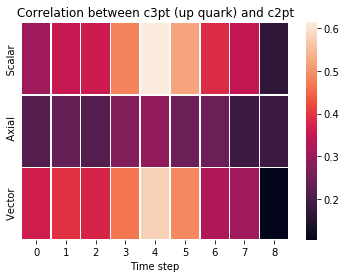

In [26]:
data = np.array([corrs_S, corrs_A, corrs_V])
ax = sns.heatmap(data, linewidth=0.5, yticklabels=False)
plt.ylabel("Vector               Axial             Scalar")
plt.title("Correlation between c3pt (up quark) and c2pt")
plt.xlabel("Time step")
plt.show()